In [1]:
import pandas as pd
from sbibm.visualisation import fig_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import numpy as np
import seaborn as sns

In [2]:
from joblib import Parallel, delayed

In [3]:
def my_fun(x, y):
    return x*y

In [6]:
inferences = Parallel(n_jobs=3)(
    delayed(my_fun)(s, 2*s) for s in range(3)
)

In [7]:
def mean_confidence_interval(data, confidence=0.95):
    return sns.utils.ci(sns.algorithms.bootstrap(data))

In [8]:
df = pd.read_pickle("../../results/results_thr2_compiled.pkl")

In [9]:
df1 = pd.read_csv("../../results/sbibm_results.csv")

In [123]:
def extract_diagnostic(df, key="gt in support"):
    full = []
    for n in [1000, 10000, 100000]:
        a = df.query(f"num_simulations=={n}")[key]
        b = np.asarray(a.to_numpy())
        all_lists = []
        for aa in b:
            aaa = aa[1:-2]
            splitted = list(aaa.split(", "))
            new_ = []
            for s in splitted:
                new_.append(float(s))
            all_lists.append(new_)
        all_lists = np.asarray(all_lists)
        full.append(all_lists)
    return np.asarray(full)

In [11]:
npe_results = df1.query("algorithm == 'NPE'")
snpe_results = df1.query("algorithm == 'SNPE'")

In [12]:
all_results = pd.concat([df, npe_results, snpe_results])

In [13]:
keywords = {}
keywords["width"] = 300 / 3
keywords["height"] = 45

style = {}
style["font_size"] = 8
style["font_family"] = "Inter"
y_axis_kwargs = {"minExtent": 60}

In [14]:
from typing import Any, Dict, List, Optional

import altair as alt
import deneb as den
import pandas as pd


def fig_metric(
    df: pd.DataFrame,
    metric: str,
    title: Optional[str] = None,
    title_dx: int = 0,
    width: Optional[int] = None,
    height: Optional[int] = None,
    labels: bool = True,
    keywords: Dict[str, Any] = {},
    style: Dict[str, Any] = {},
    default_color: str = "#000000",
    colors_dict: Dict[str, Any] = {},
    config: Optional[str] = None,
):
    """Plots metrics
    Args:
        df: Dataframe which at least has columns `algorithm`, `num_simulations` and
            a column titled accordingly to `metric`.
        metric: Metric to plot, should be a column in `df`.
        title: Title for plot
        title_dx: x-direction offset for title
        labels: Whether to plot labels
        seed: Seed
        width: Width
        height: Height
        default_color: Default color of samples
        colors_dict: Dictionary of colors
        config: Optional string to load predefined config
        style: Optional dictionary for `den.set_style`
        keywords: Optional dictionary passed on to `den.lineplot`
    Returns:
        Chart
    Note:
        Due to an open issue on vega-lite, it is difficult to sort columns in
        non-alphabetical fashion (i.e., ordered by algorithm name). As a workaround,
        consider prepending an algorithm with a space to have it listed first, e.g.
        `df.loc[df["algorithm"] == "REJ-ABC", "algorithm"] = " REJ-ABC"`.
        See also: https://github.com/vega/vega-lite/issues/5366/
    """
    colors = {}
    for algorithm in df.algorithm.unique():
        algorithm_stripped = algorithm.strip()
        if algorithm_stripped not in colors_dict:
            colors[algorithm] = default_color
        else:
            colors[algorithm] = colors_dict[algorithm_stripped]

    keywords["column_labels"] = labels
    keywords["color"] = den.colorscale(colors, shorthand="algorithm:N")

    x_axis_kwargs = {}
    y_axis_kwargs = {}

    if config == "manuscript":
        keywords["width"] = 700 / len(df.algorithm.unique()) if width is None else width
        keywords["height"] = 65 if height is None else height
        style["font_size"] = 12
        style["font_family"] = "Inter"
        y_axis_kwargs = {"minExtent": 60}

    if config == "streamlit":
        keywords["width"] = None if width is None else width
        keywords["height"] = None if height is None else height
        style["font_size"] = 16

    keywords["limits"] = None
    keywords["log_y"] = False
    keywords["y_axis"] = alt.Axis(title=metric)

    if "MMD" in metric:
        keywords["y_axis"] = alt.Axis(title="MMD²")

    if "C2ST" in metric:
        keywords["limits"] = [0.5, 1.0]
        
    if metric == "RT":
        keywords["log_y"] = True
        keywords["limits"] = [0.001, 1000.0]
        keywords["y_axis"] = alt.Axis(
            values=[0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0, 1000.0]
        )

    alt.themes.enable("default")

    den.set_style(
        extra={
            "config": {
                "axisX": {
                    "grid": False,
                    "labelAngle": 270,
                    "domain": False,
                    "domainWidth": 0,
                    "ticks": False,
                    "labels": False,
                    "tickWidth": 0,
                    "minExtent": 0,
                    **x_axis_kwargs,
                },
                "axisY": {
                    "domain": False,
                    "domainWidth": 0,
                    "ticks": True,
                    "tickWidth": 0,
                    "grid": True,
                    "titlePadding": 0,
                    "tickCount": 6.0,
                    **y_axis_kwargs,
                },
            }
        },
        **style,
    )

    chart = den.lineplot(
        df.sort_values("algorithm"),
        x="num_simulations:O",
        y=f"{metric}:Q",
        error_extent="ci",
        column="algorithm:N",
        independent_y=False,
        row_title="",
        column_title="",
        title_orient="bottom",
        **keywords,
    )

    chart = chart.configure_point(size=50).configure_line(size=1.5)

    if title is not None:
        chart = chart.properties(title={"text": [title],}).configure_title(
            offset=10,
            orient="top",
            anchor="middle",
            dx=title_dx,
        )

    return chart

In [30]:
from typing import Any, Dict, List, Optional

import altair as alt
import deneb as den
import pandas as pd


def fig_metric_mpl(
    df: pd.DataFrame,
    metric: str,
    width: float = 3.5,
    height: float = 0.8,
    xlabel: bool = True,
    title: bool = False,
    task_name: str = ""
):
    col_npe = "#8c6bb1"
    col_snpe = "#810f7c"
    col_tsnpe = "k"
    
    fig, ax = plt.subplots(1, 3, figsize=(width, height))
    
    snpe_1000 = df.query("algorithm == 'SNPE' & num_simulations == '10³'")[metric].mean()
    npe_1000 = df.query("algorithm == 'NPE' & num_simulations == '10³'")[metric].mean()
    tsnpe_1000 = df.query("algorithm == 'tsnpe' & num_simulations == 1000")[metric].mean()
    snpe_10000 = df.query("algorithm == 'SNPE' & num_simulations == '10⁴'")[metric].mean()
    npe_10000 = df.query("algorithm == 'NPE' & num_simulations == '10⁴'")[metric].mean()
    tsnpe_10000 = df.query("algorithm == 'tsnpe' & num_simulations == 10000")[metric].mean()
    snpe_100000 = df.query("algorithm == 'SNPE' & num_simulations == '10⁵'")[metric].mean()
    npe_100000 = df.query("algorithm == 'NPE' & num_simulations == '10⁵'")[metric].mean()
    tsnpe_100000 = df.query("algorithm == 'tsnpe' & num_simulations == 100000")[metric].mean()
    
    lower_conf_snpe_1000, upper_conf_snpe_1000 = mean_confidence_interval(df.query("algorithm == 'SNPE' & num_simulations == '10³'")[metric])
    lower_conf_npe_1000, upper_conf_npe_1000 = mean_confidence_interval(df.query("algorithm == 'NPE' & num_simulations == '10³'")[metric])
    lower_conf_tsnpe_1000, upper_conf_tsnpe_1000 = mean_confidence_interval(df.query("algorithm == 'tsnpe' & num_simulations == 1000")[metric])
    lower_conf_snpe_10000, upper_conf_snpe_10000 = mean_confidence_interval(df.query("algorithm == 'SNPE' & num_simulations == '10⁴'")[metric])
    lower_conf_npe_10000, upper_conf_npe_10000 = mean_confidence_interval(df.query("algorithm == 'NPE' & num_simulations == '10⁴'")[metric])
    lower_conf_tsnpe_10000, upper_conf_tsnpe_10000 = mean_confidence_interval(df.query("algorithm == 'tsnpe' & num_simulations == 10000")[metric])
    lower_conf_snpe_100000, upper_conf_snpe_100000 = mean_confidence_interval(df.query("algorithm == 'SNPE' & num_simulations == '10⁵'")[metric])
    lower_conf_npe_100000, upper_conf_npe_100000 = mean_confidence_interval(df.query("algorithm == 'NPE' & num_simulations == '10⁵'")[metric])
    lower_conf_tsnpe_100000, upper_conf_tsnpe_100000 = mean_confidence_interval(df.query("algorithm == 'tsnpe' & num_simulations == 100000")[metric])
    
    ax[0].plot([npe_1000, npe_10000, npe_100000], c=col_npe)
    ax[1].plot([snpe_1000, snpe_10000, snpe_100000], c=col_snpe)
    ax[2].plot([tsnpe_1000, tsnpe_10000, tsnpe_100000], c=col_tsnpe)
    ax[0].scatter([0, 1, 2], [npe_1000, npe_10000, npe_100000], s=20, c=col_npe)
    ax[1].scatter([0, 1, 2], [snpe_1000, snpe_10000, snpe_100000], s=20, c=col_snpe)
    ax[2].scatter([0, 1, 2], [tsnpe_1000, tsnpe_10000, tsnpe_100000], s=20, c=col_tsnpe)
    
    ax[0].plot([0, 0], [lower_conf_npe_1000, upper_conf_npe_1000], c=col_npe)
    ax[1].plot([0, 0], [lower_conf_snpe_1000, upper_conf_snpe_1000], c=col_snpe)
    ax[2].plot([0, 0], [lower_conf_tsnpe_1000, upper_conf_tsnpe_1000], c=col_tsnpe)
    ax[0].plot([1, 1], [lower_conf_npe_10000, upper_conf_npe_10000], c=col_npe)
    ax[1].plot([1, 1], [lower_conf_snpe_10000, upper_conf_snpe_10000], c=col_snpe)
    ax[2].plot([1, 1], [lower_conf_tsnpe_10000, upper_conf_tsnpe_10000], c=col_tsnpe)
    ax[0].plot([2, 2], [lower_conf_npe_100000, upper_conf_npe_100000], c=col_npe)
    ax[1].plot([2, 2], [lower_conf_snpe_100000, upper_conf_snpe_100000], c=col_snpe)
    ax[2].plot([2, 2], [lower_conf_tsnpe_100000, upper_conf_tsnpe_100000], c=col_tsnpe)
    
    for i in range(3):
        ax[i].set_ylim([0.46, 1.04])
        ax[i].spines["bottom"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].grid(axis="y", alpha=0.5)
        ax[i].set_axisbelow(True)
        ax[i].tick_params(axis=u'both', which=u'both',length=0)
        ax[i].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax[i].set_xticks([0, 1, 2])
        ax[i].set_xlim([-0.2, 2.2])
        if xlabel:
            ax[i].set_xticklabels(["10³", "10⁴", "10⁵"], rotation=90)
            ax[1].set_xlabel("Number of simulations")
        else:
            ax[i].set_xticklabels([])
        
    ax[2].set_title(task_name)
    ax[0].set_ylabel("C2ST")
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    return fig

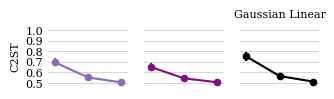

In [31]:
results_subset = all_results.query("task == 'gaussian_linear'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Gaussian Linear", title=True, xlabel=False)
    plt.savefig("../svg/panel_a.svg")

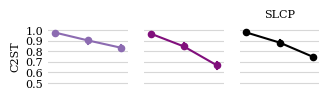

In [17]:
results_subset = all_results.query("task == 'slcp'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="SLCP", title=False, xlabel=False)
    plt.savefig("../svg/panel_b.svg")

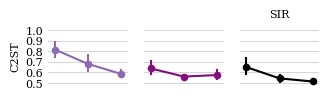

In [18]:
results_subset = all_results.query("task == 'sir'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="SIR", title=False, xlabel=False)
    plt.savefig("../svg/panel_c.svg")

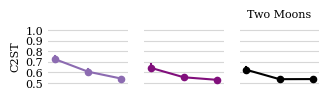

In [19]:
results_subset = all_results.query("task == 'two_moons'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Two Moons", title=False, xlabel=False)
    plt.savefig("../svg/panel_d.svg")

/home/michael/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/michael/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/michael/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


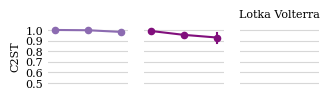

In [20]:
results_subset = all_results.query("task == 'lotka_volterra'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Lotka Volterra", title=False, xlabel=False)
    plt.savefig("../svg/panel_e.svg")

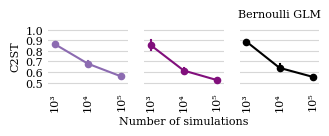

In [21]:
results_subset = all_results.query("task == 'bernoulli_glm'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_metric_mpl(results_subset, metric="C2ST", task_name="Bernoulli GLM", title=False, xlabel=True)
    plt.savefig("../svg/panel_f.svg")

In [191]:
def fig_diagnostic(
    df: pd.DataFrame,
    metric: str,
    width: float = 3.5,
    height: float = 0.7,
    xlabel: bool = True,
    title: bool = False,
    task_name: str = ""
):  
    acceptance_rate = extract_diagnostic(df.query("algorithm == 'tsnpe'"), "acceptance rate")
    print("acceptance_rate", acceptance_rate[0, 0])
    acceptance_rate[:, :, 1:] = np.power(10, acceptance_rate[:, :, 1:])
    print("acceptance_rate", acceptance_rate[0, 0])
    gt_in_support = extract_diagnostic(df.query("algorithm == 'tsnpe'"))

    av_acceptance_rate = np.mean(acceptance_rate, axis=1)
    av_gt_in_support = np.mean(gt_in_support, axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(width, height))
    ax[0].plot(np.arange(1, 11), av_acceptance_rate[0], c="k", alpha=0.3)
    ax[0].plot(np.arange(1, 11), av_acceptance_rate[1], c="k", alpha=0.55)
    ax[0].plot(np.arange(1, 11), av_acceptance_rate[2], c="k", alpha=1.0)
    ax[0].set_ylim([0, 1.01])
    ax[0].set_xlim([1, 10])
    ax[0].set_xticks(np.arange(1, 11))
    ax[0].set_ylabel("acceptance rate")
    
    ax[1].plot(np.arange(1, 11), av_gt_in_support[0], c="k", alpha=0.3)
    ax[1].plot(np.arange(1, 11), av_gt_in_support[1], c="k", alpha=0.55)
    ax[1].plot(np.arange(1, 11), av_gt_in_support[2], c="k", alpha=1.0)
    ax[1].set_ylim([0.95, 1.0001])
    ax[1].set_xlim([1, 10])
    ax[1].set_xticks(np.arange(1, 11))
    if xlabel == False:
        ax[0].set_xticklabels([])
        ax[1].set_xticklabels([])
    else:
        ax[0].set_xlabel("Round")
        ax[1].set_xlabel("Round")
    ax[1].set_ylabel("gt in support")
    plt.subplots_adjust(wspace=0.8)
    return fig

acceptance_rate [ 1.00000000e+00  0.00000000e+00 -1.08605214e-04 -7.82434770e-04
 -8.25951924e-04 -3.07263620e-03 -3.64159024e-03 -2.70101428e-03
 -3.97018017e-03 -3.97018017e-03]
acceptance_rate [1.         1.         0.99974996 0.9982     0.99809998 0.99294996
 0.99164999 0.99379998 0.99089998 0.99089998]


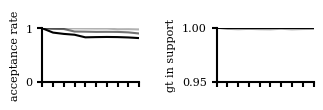

In [192]:
results_subset = all_results.query("task == 'gaussian_linear'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="Gaussian Linear", title=True, xlabel=False)
    plt.savefig("../svg/panel_a2.svg")

acceptance_rate [ 1.         -0.00128307 -0.00191512 -0.00117419 -0.00158808 -0.00139199
 -0.00141376 -0.00132664 -0.00152272 -0.00324763]
acceptance_rate [1.         0.99704999 0.99559999 0.99729997 0.99634999 0.99679995
 0.99675    0.99694997 0.99649996 0.99254996]


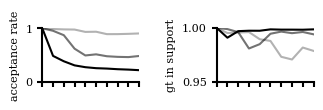

In [193]:
results_subset = all_results.query("task == 'slcp'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False)
    plt.savefig("../svg/panel_b2.svg")

acceptance_rate [ 1.         -0.00298515 -0.0039921  -0.00539694 -0.00986103 -0.04438441
 -0.04162728 -0.15391044 -0.37757874 -0.40135536]
acceptance_rate [1.         0.99315    0.99084997 0.98764998 0.97754997 0.90284997
 0.90859997 0.70159996 0.41919999 0.39686669]


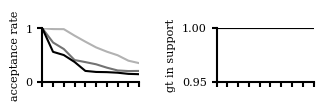

In [194]:
results_subset = all_results.query("task == 'sir'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False)
    plt.savefig("../svg/panel_c2.svg")

acceptance_rate [ 1.         -0.16275889 -0.14569397 -0.27372119 -0.30598012 -0.27860165
 -0.48681569 -0.54526949 -0.54925066 -0.50797337]
acceptance_rate [1.         0.68745    0.71499998 0.53244998 0.49433332 0.52649997
 0.32597501 0.28492497 0.282325   0.31047499]


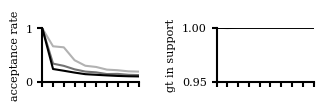

In [195]:
results_subset = all_results.query("task == 'two_moons'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=False)
    plt.savefig("../svg/panel_d2.svg")

acceptance_rate [ 1.         -0.00917295 -0.01146335 -0.01170866 -0.05381804 -0.07582413
 -0.0960694  -0.31113544 -0.29149413 -0.33964056]
acceptance_rate [1.         0.97909999 0.97394997 0.9734     0.88344997 0.83980001
 0.80154997 0.48849999 0.51109999 0.45746665]


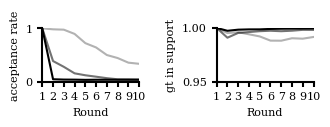

In [196]:
results_subset = all_results.query("task == 'bernoulli_glm'")
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = fig_diagnostic(results_subset, metric="C2ST", task_name="SLCP", title=True, xlabel=True)
    plt.savefig("../svg/panel_f2.svg")

In [197]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [201]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("15.7cm", "13.9cm",

    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 0),
    Panel(
          SVG("../svg/panel_b.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 93),
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 171),
    Panel(
          SVG("../svg/panel_d.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 249),
    Panel(
          SVG("../svg/panel_e.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 327),
    Panel(
          SVG("../svg/panel_f.svg").scale(svg_scale).move(0, 0),
    ).move(-5, 405),
           
    Panel(
          SVG("../svg/panel_a2.svg").scale(svg_scale).move(0, 0),
    ).move(300, 0),
    Panel(
          SVG("../svg/panel_b2.svg").scale(svg_scale).move(0, 0),
    ).move(300, 93),
    Panel(
          SVG("../svg/panel_c2.svg").scale(svg_scale).move(0, 0),
    ).move(300, 171),
    Panel(
          SVG("../svg/panel_d2.svg").scale(svg_scale).move(0, 0),
    ).move(300, 249),
    Panel(
          SVG("../svg/panel_f2.svg").scale(svg_scale).move(0, 0),
    ).move(300, 405),
)

f.save("../fig/fig4.svg")
svg('../fig/fig4.svg')